# Time Series Analysis con RNN - IP Helados/Postres Helados

Dataset de https://fred.stlouisfed.org/series/IPN31152N

Resultados: bastante malos

In [93]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
data = pd.read_csv("Frozen_Dessert_Production.csv", index_col="DATE", parse_dates=True)
data.columns = ["Production"]
data

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


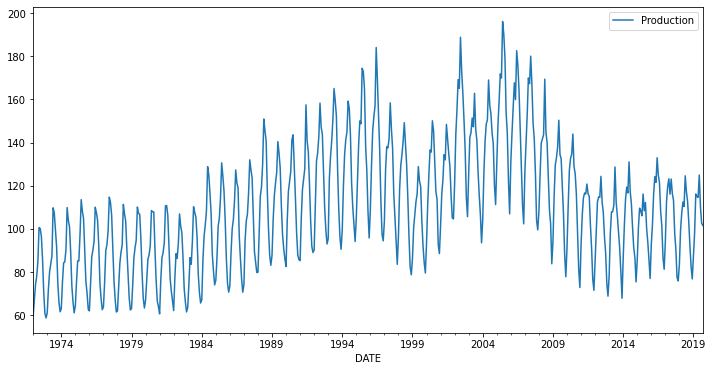

In [95]:
data.plot(figsize=(12,6))

In [109]:
# train, test, split
test_s = 24
test_i = len(data)-test_s

train = data.iloc[:test_i]
test = data.iloc[test_i:]

In [110]:
# normalizar los datos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train_data = scaler.fit_transform(train)
scaled_test_data = scaler.transform(test)

In [111]:
# generador de time series
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 18
num_features = 1
time_series_generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length = length, batch_size = 1)

In [112]:
# creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()

model.add(LSTM(1000, input_shape = (length, num_features), activation="tanh"))

model.add(Dense(1, activation="tanh"))

model.compile(loss="mse", optimizer="adam")

In [113]:
# generador de time series para los datos de test
val_generator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=length, batch_size=1)

In [114]:
# introducción del early stop
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=2)

In [115]:
#entrenamiento
model.fit(time_series_generator, epochs=25, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/25
531/531 [==============================] - 87s 163ms/step - loss: 0.0131 - val_loss: 0.0035
Epoch 2/25
531/531 [==============================] - 86s 163ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 3/25
531/531 [==============================] - 88s 167ms/step - loss: 0.0050 - val_loss: 0.0049


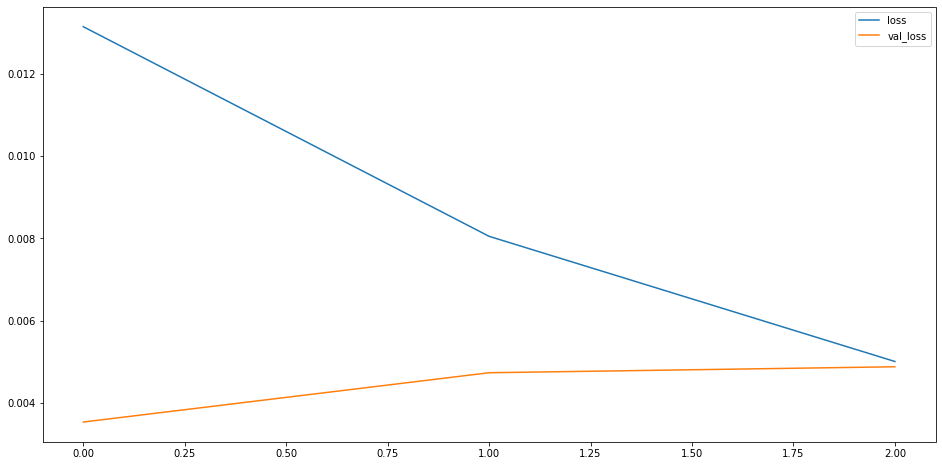

In [116]:
# ploteo del error
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(16,8))

In [117]:
# predicciones
test_predictions = []

first_batch = scaled_train_data[-length:]
current_batch = first_batch.reshape((1,length,num_features))

for i in range(len(test)):
  current_prediction = model.predict(current_batch)[0]
  test_predictions.append(current_prediction)

  current_batch = np.append(current_batch[:,1:,:],[[current_prediction]],axis=1)

In [118]:
# denormalizar las predicciones y agregarlas al df original
unscaled_predictions = scaler.inverse_transform(test_predictions)

test["Predictions"] = unscaled_predictions

test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Production,Predictions
DATE,,
2017-10-01,90.4732,90.206316
2017-11-01,77.4378,88.140716
2017-12-01,75.8118,91.416249
2018-01-01,83.4343,100.204967
2018-02-01,99.4899,111.298065
2018-03-01,107.3152,121.840120
2018-04-01,112.4309,130.122101
2018-05-01,110.3544,135.174862
2018-06-01,124.5841,136.326548


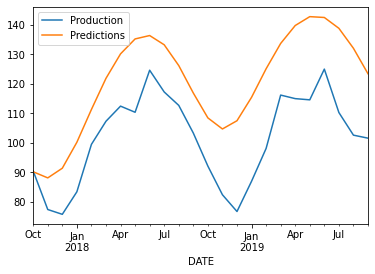

In [119]:
 #evaluar los resultados
 test.plot()

In [120]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test["Production"], test["Predictions"]))

20.500014022167207